# Demonstrating PERCIVAL

See "Learning Bayes' theorem with a neural network for gravitational-wave inference" by A. J. K. Chua and M. Vallisneri ([arXiv:1904.05355](http://www.arxiv.org/abs/1904.05355)).

*Michele and Alvin, 9/23/2019*

## Install

Install the `TrueBayes` Python package from [source on GitHub](https://github.com/vallis/truebayes).

In [5]:
!pip install --upgrade git+https://github.com/vallis/TrueBayes.git

  Cloning https://github.com/vallis/TrueBayes.git to /tmp/pip-req-build-e2sfqclc
  Running command git clone -q https://github.com/vallis/TrueBayes.git /tmp/pip-req-build-e2sfqclc
  Created wheel for truebayes: filename=truebayes-0.1-cp36-none-any.whl size=39007926 sha256=ce5fd95508b9cca120888c4aebc43653a854f2386bd1f9bb53ced42a2fd9c841
  Stored in directory: /tmp/pip-ephem-wheel-cache-dhvku8td/wheels/4a/12/e9/5a242fa093b9548099d49990a4ddec72de4d67aa6dc5e1b253
Successfully built truebayes


## Imports

Just standard packages in the Python data-science stack, plus [PyTorch](https://pytorch.org) and our own `TrueBayes`. BTW, if you are on Google Colaboratory, be sure to run this notebook with a GPU-enabled instance.

In [0]:
import os
import math

In [0]:
import numpy as np
import matplotlib.pyplot as pp

%matplotlib inline

In [0]:
import torch

In [0]:
import truebayes.network
import truebayes.geometry
import truebayes.roman
import truebayes.loss
import truebayes.like
import truebayes.plot

## Source-parameter posterior inference for a 3D template family (chirp mass, mass ratio, SNR)

### Set up networks

The PERCIVAL network consists of the input layer for the 482 ROMAN weights (241 complex numbers); of 8 1024-wide hidden layers; and of an output layer describing the six parameters of a two-dimensional joint normal distribution. By default, we work in single precision; `softmax=True` is required for Gaussian-mixture posteriors.

In [0]:
Net_roman_G2 = truebayes.network.makenet([241*2] + [1024] * 8 + [1*6], softmax=False)

nrg2 = Net_roman_G2()

Here is how we train this network. We set up a training-set *factory* over a rectangular Mc-nu region, uniformly distributed in SNR. This factory will produce batches of 100000 signal + noise ROMAN coefficients, with the corresponding "true" parameters. Noise is normalized (set to 1), as appropriate for training with noisy signals.

Specifying `varx` as `['Mc','nu']` returns a training set appropriate for 1D training.

In [0]:
trainingset = lambda: truebayes.roman.syntrain(snr=[8,16], size=100000, varx=['Mc','nu'], region=[[0.26,0.47], [0.2,0.25]])

As an example, we train over 100 iterations (1e6 total signals), which takes a few minutes on Google Colab's K80 Tesla GPU. You'd need a factor of 10 or 100 more to achieve a sufficiently trained network.

In [0]:
%%time
truebayes.roman.syntrainer(nrg2, trainingset, lossfunction=truebayes.loss.kllossGn2,
                           iterations=100, initstep=1e-4, finalv=1e-8)

0 7.643424034118652 
One epoch = 9.8 seconds.
50 -1.5110187530517578 
Final -1.6394630670547485 
CPU times: user 4min 42s, sys: 2min 16s, total: 6min 58s
Wall time: 6min 59s


To demonstrate PERCIVAL in inference mode without you having to train it, we're including a trained network in the `TrueBayes` package. After loading the network we set it into inference model to skip all the PyTorch back-propagation accounting.


In [0]:
nrg2.load_state_dict(torch.load(truebayes.roman.datadir + 'percival/Mc-nu_l1024x8_g1_SNR8-16_2d.pt'))
nrg2.eval();

### Setup test examples and template factories

To test our network, we need more examples (let's say 5000), drawn from the same parameter region where we have trained it. We get them with another factory.  (Note that we set `varall=True`, to save all source parameters. Below we grab those into arrays.)

In [0]:
mutest = truebayes.roman.syntrain(snr=[8,16], size=5000, varx='Mc', region=[[0.26,0.47], [0.2,0.25]], noise=1, varall=True, seed=2)

In [0]:
Mc = mutest[0][:,0]
nu = mutest[0][:,1]
snr = mutest[0][:,4]

# we will be sorting our plots by chirp mass
idx = np.argsort(Mc)

We need more factories to compare the output of our network with actual posteriors. These draw parameters and make signals in the same parameter region, but without noise.

In [0]:
likeset_Mc = lambda: truebayes.roman.syntrain(snr=[8,16], size=100000, varx='Mc', region=[[0.26,0.47], [0.2,0.25]], noise=0)

In [0]:
likeset_nu = lambda: truebayes.roman.syntrain(snr=[8,16], size=100000, varx='nu', region=[[0.26,0.47], [0.2,0.25]], noise=0)

In [0]:
likeset_2 = lambda: truebayes.roman.syntrain(snr=[8,16], size=100000, varx=['Mc','nu'], region=[[0.26,0.47], [0.2,0.25]], noise=0)

### Plot 1-D histograms from 1-D and 2-D networks

Evaluate 1D posterior histograms (using the actual likelihood, not the network) for the first 24 signals in the test set.

In [16]:
%%time
sl_Mc = truebayes.like.synlike(mutest[2][:24,:], likeset_Mc, iterations=10000000)

CPU times: user 18 s, sys: 10.4 s, total: 28.4 s
Wall time: 28.6 s


In [17]:
%%time
sl_nu = truebayes.like.synlike(mutest[2][:24,:], likeset_nu, iterations=10000000)

CPU times: user 18.2 s, sys: 10.7 s, total: 28.9 s
Wall time: 29 s


Compare likelihood- and network-based histograms for chirp mass and mass ratio.

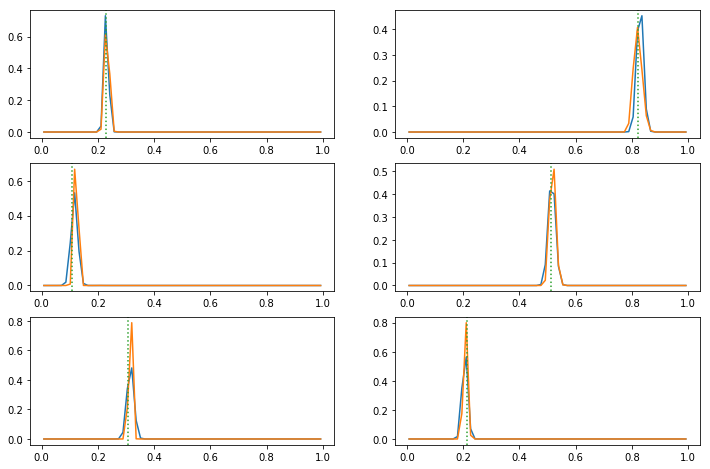

In [18]:
truebayes.plot.plotgauss(*mutest, net=nrg2, varx='Mc', like=sl_Mc, twodim=True, istart=6)

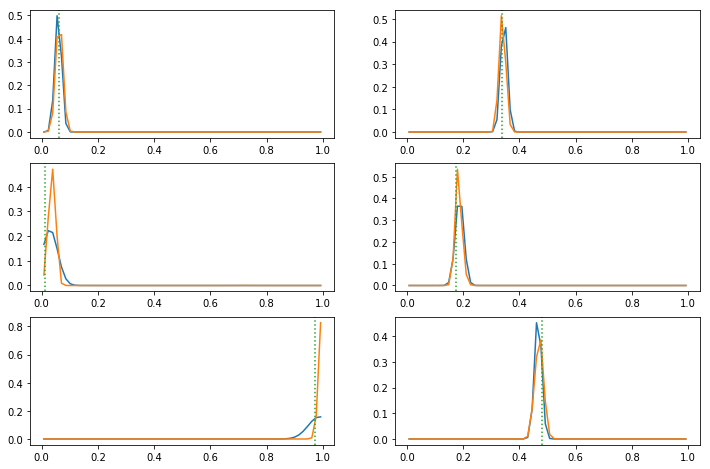

In [19]:
truebayes.plot.plotgauss(*mutest, net=nrg2, varx='nu', like=sl_nu, twodim=True, istart=6)

### Plot 2-D histogram from 2-D network

In [20]:
%%time
sl2 = truebayes.like.synlike(mutest[2][:24,:], likeset_2, iterations=10000000)

CPU times: user 3min 59s, sys: 21.6 s, total: 4min 21s
Wall time: 4min 21s


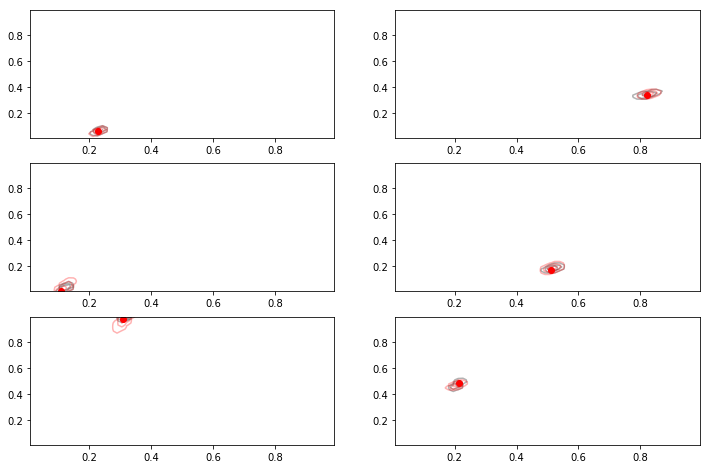

In [21]:
truebayes.plot.makecontour(*mutest, net=nrg2, like=sl2, istart=6)

### Compare 1D and 2D means and variances.

We use the training-set factories defined above to compute likelihood-based conditional means and std deviations.

In [24]:
%%time
lm, le = truebayes.like.synmean(mutest[2], likeset_Mc, iterations=10000000)

CPU times: user 28.6 s, sys: 21.7 s, total: 50.3 s
Wall time: 50.6 s


In [25]:
%%time
lm_nu, le_nu  = truebayes.like.synmean(mutest[2], likeset_nu, iterations=10000000)

CPU times: user 29.4 s, sys: 22.1 s, total: 51.5 s
Wall time: 51.9 s


In [26]:
%%time
lm2, le2, lc2 = truebayes.like.synmean(mutest[2], likeset_2, iterations=10000000)

CPU times: user 2min 19s, sys: 23.1 s, total: 2min 42s
Wall time: 2min 42s


By contrast, these are the predictions of the PERCIVAL network.

In [0]:
nm2, ne2, nc2 = truebayes.loss.netmeanGn2(mutest[2], net=nrg2)

Let's plot! We start with the differences between the predicted and actual conditional means.

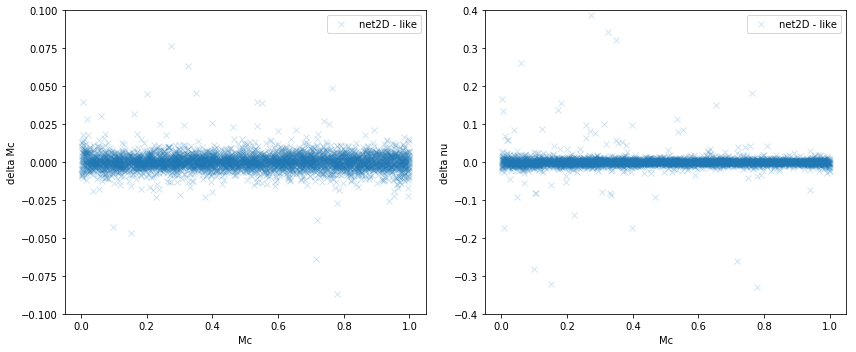

In [28]:
pp.figure(figsize=(12,5))

idx = np.argsort(Mc)

pp.subplot(1,2,1)
pp.plot(Mc[idx], nm2[idx,0]  - lm2[idx,0], 'x', label='net2D - like', alpha=0.2)
pp.xlabel('Mc'); pp.ylabel('delta Mc'); pp.legend()
pp.axis(ymin=-0.1,ymax=0.1)

pp.subplot(1,2,2)
pp.plot(Mc[idx], nm2[idx,1]  - lm2[idx,1], 'x', label='net2D - like', alpha=0.2)
pp.xlabel('Mc'); pp.ylabel('delta nu'); pp.legend()
pp.axis(ymin=-0.4,ymax=0.4)

pp.tight_layout()

We continue with the fractional error in the predicted standard deviations vs. the actual values.

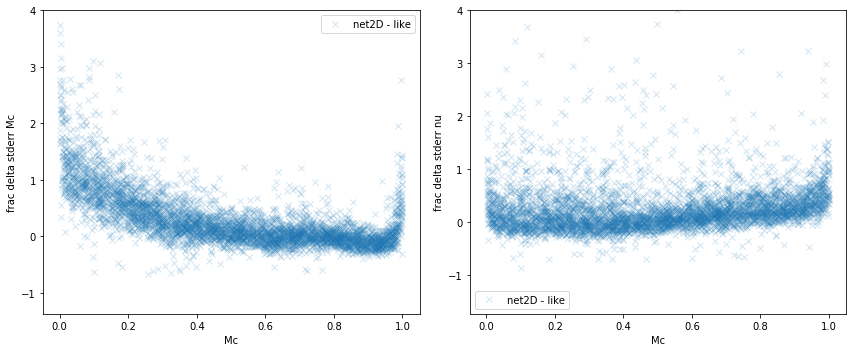

In [29]:
pp.figure(figsize=(12,5))

idx = np.argsort(Mc)

pp.subplot(1,2,1)
pp.plot(Mc[idx], (ne2[idx,0]  - le2[idx,0])/le2[idx,0], 'x', label='net2D - like', alpha=0.2)
pp.xlabel('Mc'); pp.ylabel('frac delta stderr Mc'); pp.legend(); pp.axis(ymax=4)

pp.subplot(1,2,2)
pp.plot(Mc[idx], (ne2[idx,1]  - le2[idx,1])/le2[idx,1], 'x', label='net2D - like', alpha=0.2)
pp.xlabel('Mc'); pp.ylabel('frac delta stderr nu'); pp.legend(); pp.axis(ymax=4)

pp.tight_layout()

Last, we compare correlation values.

(-0.04893208827291221, 1.0497994266805195, -0.5, 0.5)

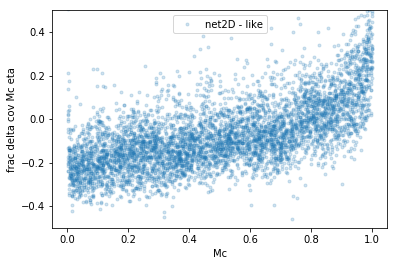

In [30]:
ncov = nc2 / ne2[:,0] / ne2[:,1]
lcov = lc2 / le2[:,0] / le2[:,1]

pp.plot(Mc[idx], ncov[idx] - lcov[idx], '.', label='net2D - like', alpha=0.2)
pp.xlabel('Mc'); pp.ylabel('frac delta cov Mc eta'); pp.legend(); pp.axis(ymin=-0.5, ymax=0.5)